<h1>Load yours data</h1>

In [11]:
# -- Import --
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import ccxt
sys.path.append( '../../utilities' )
from data_engine import DataEngine

# -- You can change the crypto pair ,the start date and the time interval below --
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Successfully load 39409 candles for ETHUSDT
Data loaded 100%


<h1>Define your indicators</h1>

In [12]:
# -- Indicator variable --
trixLength = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)


print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-19 06:00:00,2809.28,2825.98,2803.35,2819.61,12220.41860,2824.994040,-0.108258,-0.183367,0.075109,1.000000
2022-02-19 07:00:00,2819.61,2825.00,2807.36,2812.05,6283.07500,2822.483896,-0.088855,-0.181559,0.092705,0.890533
2022-02-19 08:00:00,2812.05,2819.33,2780.04,2781.82,14630.24800,2820.191841,-0.081207,-0.180020,0.098813,0.508114


<h1>Stoch RSI optimizer</h1>


In [10]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2017-01-01':]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, stochOverSold):
  if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
  else:
        return False

loopI = [50, 100, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [0, 50, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    stochTop = i / 100
    stochBottom = j /100

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row, stochBottom) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

Loading... 7 / 2500


KeyboardInterrupt: 

<h2>Trix Optimizer</h2>

Loading... 576 / 576


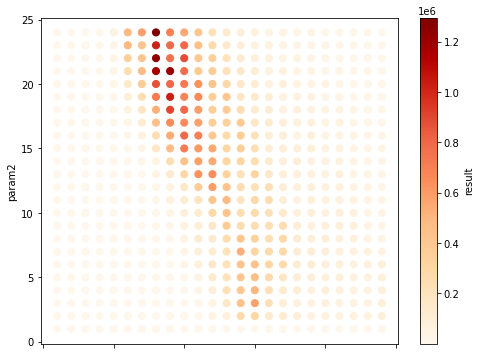

     param1  param2        result
18      1.0    19.0  5.048177e-01
22      1.0    23.0  5.057400e-01
17      1.0    18.0  5.266323e-01
11      1.0    12.0  5.452014e-01
23      1.0    24.0  6.369620e-01
..      ...     ...           ...
210     9.0    19.0  1.031962e+06
188     8.0    21.0  1.175499e+06
212     9.0    21.0  1.213579e+06
189     8.0    22.0  1.248386e+06
191     8.0    24.0  1.296246e+06

[576 rows x 3 columns]


In [ ]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2017-01-01':]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, stochOverSold):
  if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
  else:
        return False

loopI = [1, 25, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [1, 25, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    # -- Indicators, you can edit every value --
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'], trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    stochTop = 0.85
    stochBottom = 0.29

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row, stochBottom) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>Stock RSI Optimizer</h1>

Loading... 49 / 49


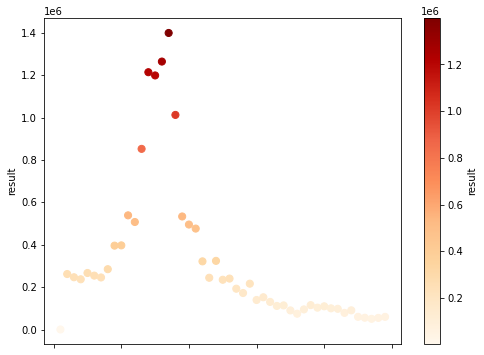

    param1        result
0      1.0  1.000000e+03
46    47.0  5.119176e+04
47    48.0  5.562506e+04
45    46.0  5.636205e+04
48    49.0  6.045951e+04
44    45.0  6.059187e+04
35    36.0  7.529580e+04
42    43.0  7.924227e+04
34    35.0  9.085297e+04
43    44.0  9.123858e+04
36    37.0  9.555193e+04
41    42.0  9.835749e+04
40    41.0  1.006679e+05
38    39.0  1.037745e+05
39    40.0  1.101962e+05
32    33.0  1.118746e+05
33    34.0  1.144751e+05
37    38.0  1.158027e+05
31    32.0  1.308969e+05
29    30.0  1.400008e+05
30    31.0  1.528386e+05
27    28.0  1.728788e+05
26    27.0  1.931420e+05
28    29.0  2.168586e+05
24    25.0  2.353155e+05
3      4.0  2.375852e+05
25    26.0  2.409258e+05
22    23.0  2.447361e+05
6      7.0  2.461616e+05
2      3.0  2.471677e+05
5      6.0  2.548601e+05
1      2.0  2.623174e+05
4      5.0  2.672352e+05
7      8.0  2.851577e+05
21    22.0  3.220806e+05
23    24.0  3.243324e+05
8      9.0  3.961352e+05
9     10.0  3.974132e+05
20    21.0  4.765850e+05


In [17]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2017-01-01':]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, stochOverSold):
  if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
  else:
        return False

loopI = [1, 50, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

    stochTop = 0.85
    stochBottom = 0.29

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row, stochBottom) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))

<h1>All Trix Parameters optimizer</h1>

In [ ]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'param3', 'param4', 'param5', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# Test small date
dfTest = df['2021-06-01':]


# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, stochOverSold):
  if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
  else:
        return False

#seuil survente
loopI = [19, 31, 1] 
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

#seuil sur achat
loopJ = [83, 88, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

#Stoch RSI
loopK = [8, 18, 1]
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

#Tix length
loopL = [8, 15, 1]
enumL = ceil((loopL[1] - loopL[0]) / loopL[2])

#Trix signal
loopM = [8, 23, 1]
enumM = ceil((loopM[1] - loopM[0]) / loopM[2])

count = 0
maxCount = enumI * enumJ * enumK * enumL * enumM
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    for k in range(loopK[0], loopK[1], loopK[2]):
      for l in range(loopL[0], loopL[1], loopL[2]):
        for m in range(loopM[0], loopM[1], loopM[2]):
          clear_output(wait=True)
          count += 1
          print("Loading...",count,'/',maxCount)
          # -- You can change variables below --
          usdt = 1000
          coin = 0

          stochOverSold = i / 100
          stochOverBought = j / 100
          windowRsi = k
          trixLength = l
          trixSignal = m
          dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=windowRsi, smooth1=3, smooth2=3)
          dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
          dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
          dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'],trixSignal)
          dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

          fpreviousRow = dfTest.iloc[0]

          for index, row in dfTest.iterrows():
            #BUY
            if buyCondition(row, stochTop) and usdt > 0:
              coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
              usdt = 0

            #SELL
            elif sellCondition(row, stochBottom) and coin > 0:
              usdt = coin * row['close'] - (0.0007 * coin * row['close'])
              coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)  

# dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='rainbow',figsize=(8,6))
# plt.show()

# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(dt['param1'], dt['param2'], dt['param3'],c=dt['result'],cmap='OrRd', s=30)
# plt.show()

print(dt.sort_values(by=['result']))

Loading... 39 / 63000


/home/eliott/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eliott/.local/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/eliott/.local/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

KeyboardInterrupt: 